In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv,pinv

In [2]:
# def make_hann_2D(n):
#     w = scipy.signal.hann(n)
#     wx,wy = np.meshgrid(w,w)
#     w2 = wx*wy
#     return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def vec2arr(v):
    return np.array(v).flatten()

In [3]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)
print(np.min(lmaggrid[lmaggrid!=0]),np.max(lmaggrid))

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))/np.sqrt(2.)/(10+lmaggrid)
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

mask = random.randn(n,n)>-.1

(144.0, 5091.1688245431424)


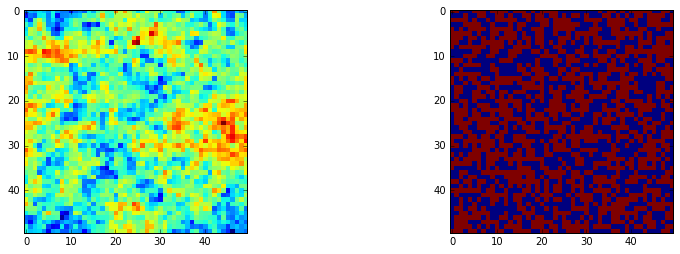

In [4]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')

plt.subplot(122)
plt.imshow(mask,interpolation='nearest')

5091.16882454
5091.16882454


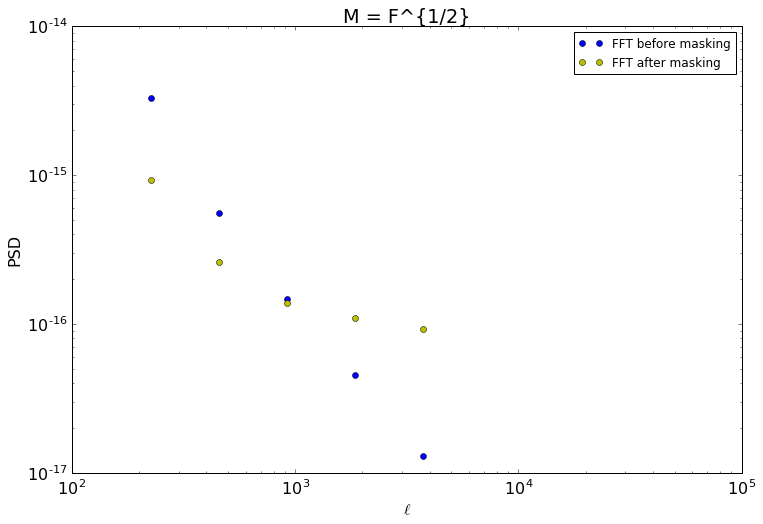

In [5]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,8))
 
lmin,lmax = 150,5000
nbins = 5
img_meas = img*mask
uselogbins = True
usehann = False

lbins,pspec,bin_counts = img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann)
lbins,pspec_m,bin_counts = img2PS(img_meas,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann)

plt.loglog(lbins,pspec,'bo',label='FFT before masking')
plt.loglog(lbins,pspec_m,'yo',label='FFT after masking') 

plt.legend(fontsize=12)
plt.title('M = F^{1/2}')
plt.xlim([100,1.e5])
plt.xlabel('$\ell$')
plt.ylabel('PSD')

In [12]:
def img2optPS(img_meas,pguess,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,interp_pguess=False,verbose=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
#     if interp_pguess:
#         print('a')
        # generate the fourier transform matrix
    lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2

    Cguess_ft = matrix(np.diag( np.interp(lmaggrid.flatten(),lbincenters,pguess/norm/n**2) ))        
#     Csignal = F*Cguess_ft*conj(F).T
            
#     print('c')
#     Cmask = 1.e7*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
#     print('d')
#     Cinv = inv(Csignal + Cmask)

    Fbar = F[img_meas.flatten()==0,:]
    FP = F - F*conj(Fbar.T)*inv(Fbar*conj(Fbar.T))*Fbar
    Cinv = FP*inv(Cguess_ft+conj(Fbar.T)*Fbar)*conj(FP.T) # pseudo inverse
    
    print('e')
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('bins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    
    return lbincenters,p,Fish
#     return eigvals

In [ ]:
# lbins,pspec_opt_l0,Fish_l0 = img2optPS(img_meas,np.ones(nbins),dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=False,verbose=True)
# lbins,pspec_opt_l1,Fish_l1 = img2optPS(img_meas,1./(10+lbins),dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=False,verbose=False)
# lbins,pspec_opt_l2,Fish_l2 = img2optPS(img_meas,1./(10+lbins)**2,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=False,verbose=False)

lbins,pspec_opt_l0_interp,Fish_l0_interp = img2optPS(img_meas,np.ones(nbins),dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=True,verbose=False)
lbins,pspec_opt_l1_interp,Fish2_l1_interp = img2optPS(img_meas,1./(10+lbins),dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=True,verbose=False)
lbins,pspec_opt_l2_interp,Fish3_l2_interp = img2optPS(img_meas,1./(10+lbins)**2,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=usehann,interp_pguess=True,verbose=False)


dl = 144
e
bins:  0 1 2 3 4 
fisher row:  0 1 2 3 4 
dl = 144
e
bins:  0 1 2 3 4 
fisher row:  0 1

In [ ]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,8))
 
# plt.loglog(lbins,pspec_opt_l0,'r-',label='Pguess = 1',linewidth=2)
# plt.loglog(lbins,pspec_opt_l1,'g-',label='Pguess = 1/(10+\ell)',linewidth=2)
# plt.loglog(lbins,pspec_opt_l2,'b-',label='Pguess = 1/(10+\ell)^2',linewidth=2)

plt.loglog(lbins,pspec_opt_l0_interp,'r--',label='Pguess = 1, interp',linewidth=2)
plt.loglog(lbins,pspec_opt_l1_interp,'g--',label='Pguess = 1/(10+\ell), interp',linewidth=2)
plt.loglog(lbins,pspec_opt_l2_interp,'b--',label='Pguess = 1/(10+\ell)^2, interp',linewidth=2)

plt.loglog(lbins,pspec,'bo',label='FFT before masking')
plt.loglog(lbins,pspec_m,'yo',label='FFT after masking') 

plt.legend(fontsize=12)
plt.title('M = F^{-1/2}')
plt.xlim([100,1.e4])
plt.ylim([5.e-18,2.e-15])
plt.xlabel('$\ell$')
plt.ylabel('PSD')

plt.savefig('pspec_sim_pinv.png',bbox_inches='tight')